In [1]:
import os
import pickle 
import joblib
import pandas as pd
import numpy as np
import random
import itertools
from datetime import datetime, timedelta
# import matplotlib.dates as mdates

# import matplotlib.pyplot as plt
# plt.style.use('tableau-colorblind10')

import sys
sys.path.append('/data/Hydra_Work/Competition_Functions') 
from Processing_Functions import process_forecast_date, process_seasonal_forecasts
from Data_Transforming import read_nested_csvs, generate_daily_flow, use_USGS_flow_data, USGS_to_daily_df_yearly
from Full_LSTM_ML_Functions import SumPinballLoss


sys.path.append('/data/Hydra_Work/Pipeline_Functions')
from Folder_Work import filter_rows_by_year, csv_dictionary, add_day_of_year_column


from datetime import datetime
import torch
import torch.nn as nn


In [2]:
"""import os
import shutil

# Define the base directory
base_dir = "/data/Hydra_Work/1_Day_No_Forecast_Validation_Models"

# Define the set of Val_Years and Models
val_years = list(range(2000, 2024, 2))  # Even years between 2000 and 2024
model1 = "General_LSTM_Model"
model2 = "General_LSTM_No_Flow_Model"

# Function to swap the contents of two directories
def swap_directories(dir1, dir2):
    temp_dir = dir1 + "_temp"
    # Move dir1 to temp_dir
    shutil.move(dir1, temp_dir)
    # Move dir2 to dir1
    shutil.move(dir2, dir1)
    # Move temp_dir to dir2
    shutil.move(temp_dir, dir2)

# Swap the contents for each year
for year in val_years:
    dir1 = os.path.join(base_dir, str(year), model1)
    dir2 = os.path.join(base_dir, str(year), model2)
    swap_directories(dir1, dir2)
    print(f"Swapped contents of {dir1} and {dir2}")
"""

'import os\nimport shutil\n\n# Define the base directory\nbase_dir = "/data/Hydra_Work/1_Day_No_Forecast_Validation_Models"\n\n# Define the set of Val_Years and Models\nval_years = list(range(2000, 2024, 2))  # Even years between 2000 and 2024\nmodel1 = "General_LSTM_Model"\nmodel2 = "General_LSTM_No_Flow_Model"\n\n# Function to swap the contents of two directories\ndef swap_directories(dir1, dir2):\n    temp_dir = dir1 + "_temp"\n    # Move dir1 to temp_dir\n    shutil.move(dir1, temp_dir)\n    # Move dir2 to dir1\n    shutil.move(dir2, dir1)\n    # Move temp_dir to dir2\n    shutil.move(temp_dir, dir2)\n\n# Swap the contents for each year\nfor year in val_years:\n    dir1 = os.path.join(base_dir, str(year), model1)\n    dir2 = os.path.join(base_dir, str(year), model2)\n    swap_directories(dir1, dir2)\n    print(f"Swapped contents of {dir1} and {dir2}")\n'

In [3]:
basins = ['libby_reservoir_inflow',  'owyhee_r_bl_owyhee_dam',  'san_joaquin_river_millerton_reservoir',  'taylor_park_reservoir_inflow',
 'boise_r_nr_boise', 'green_r_bl_howard_a_hanson_dam', 'weber_r_nr_oakley', 'detroit_lake_inflow', 'virgin_r_at_virtin', 'dillon_reservoir_inflow',
 'pueblo_reservoir_inflow', 'hungry_horse_reservoir_inflow', 'stehekin_r_at_stehekin', 'pecos_r_nr_pecos', 'snake_r_nr_heise', 'yampa_r_nr_maybell',
 'colville_r_at_kettle_falls', 'missouri_r_at_toston', 'merced_river_yosemite_at_pohono_bridge', 'animas_r_at_durango','fontenelle_reservoir_inflow', 'boysen_reservoir_inflow']

selected_years = range(2000,2024,2)


base_dir = "/data/Hydra_Work/Scaled_Data"

# Define dictionaries and DataFrames
dictionaries = ['era5', 'seasonal_forecasts', 'daily_flow', 'climatological_flows']

dataframes = ['climate_indices', 'static_variables']

# Function to load dictionaries
def load_dictionaries(base_dir, names):
    loaded_dicts = {}
    for name in names:
        file_path = os.path.join(base_dir, f"{name}.pkl")
        with open(file_path, 'rb') as file:
            locals()[name] = pickle.load(file)
    return locals()

# Function to load DataFrames
def load_dataframes(base_dir, names):
    loaded_dfs = {}
    for name in names:
        file_path = os.path.join(base_dir, f"{name}.pkl")
        locals()[name] = pd.read_pickle(file_path)
    return locals()

saved_dicts = load_dictionaries(base_dir, dictionaries)
saved_dfs = load_dataframes(base_dir, dataframes)

for name in dictionaries:
    locals()[name] = saved_dicts[name]

for name in dataframes:
    locals()[name] = saved_dfs[name]

criterion = SumPinballLoss(quantiles = [0.1, 0.5, 0.9])

basin = 'animas_r_at_durango' 
All_Dates = daily_flow[basin].index[
    ((daily_flow[basin].index.month < 6) | ((daily_flow[basin].index.month == 6) & (daily_flow[basin].index.day < 24))) &
    ((daily_flow[basin].index.year % 2 == 0) | ((daily_flow[basin].index.month > 10) | ((daily_flow[basin].index.month == 10) & (daily_flow[basin].index.day >= 1))))
]
All_Dates = All_Dates[All_Dates.year > 1998]


# Validation Year
Val_Dates = All_Dates[All_Dates.year >= 2020]
All_Dates = All_Dates[All_Dates.year < 2020]

device = torch.device('cuda' if torch.cuda.
                is_available() else 'cpu')



In [4]:
def calculate_climatological_flows(years_to_include, daily_flow):
    climatological_flows = {}

    for basin, df in daily_flow.items():
        df = df[df.index.year.isin(years_to_include)].copy()
        # Extract day of year and flow values
        df['day_of_year'] = df.index.dayofyear

        grouped = df.groupby('day_of_year')['daily_flow'].quantile([0.1, 0.5, 0.9]).unstack(level=1)

        climatological_flows[basin] = pd.DataFrame({
            'day_of_year': grouped.index,
            '10th_percentile_flow': grouped[0.1],
            '50th_percentile_flow': grouped[0.5],
            '90th_percentile_flow': grouped[0.9]
        })
        
        climatological_flows[basin].set_index('day_of_year', inplace=True)

        # Drop the temporary 'day_of_year' column from the original dataframe
        df.drop(columns='day_of_year', inplace=True)
    return climatological_flows

In [5]:
test_year = 2008
years = np.arange(2000,2024,2)
years_to_include = new_list = [year for year in years if year != test_year]
print(years_to_include)
climatological_flows = calculate_climatological_flows(years_to_include, daily_flow)
climatological_flows['animas_r_at_durango']


[2000, 2002, 2004, 2006, 2010, 2012, 2014, 2016, 2018, 2020, 2022]


,10th_percentile_flow,50th_percentile_flow,90th_percentile_flow
day_of_year,,,
1,-0.615211,-0.575178,-0.522201
2,-0.630515,-0.574000,-0.529264
3,-0.638756,-0.576362,-0.539860
4,-0.636401,-0.571646,-0.516319
5,-0.636401,-0.575178,-0.538683
...,...,...,...
362,-0.591311,-0.561645,-0.531979
363,-0.594254,-0.562234,-0.530214
364,-0.592370,-0.557525,-0.522679


# Evaluation Plots

In [6]:
import joblib
import sys
sys.path.append('/data/Hydra_Work/Performance_Evaluation') 
from Evaluation_Functions import test_weekly_performance, test_weekly_performance_hydra



In [29]:
def quantile_loss(predictions, true_values, quantiles = np.array([0.1,0.5,0.9])):
    """
    Compute the quantile loss for multiple quantiles.

    Parameters:
    predictions (numpy.ndarray): Array of shape (k, n) where k is the number of quantiles and n is the number of predictions.
    true_values (numpy.ndarray): Array of shape (n,) containing the true values.
    quantiles (numpy.ndarray): Array of shape (k,) containing the quantile values.

    Returns:
    numpy.ndarray: Array of shape (k,) containing the quantile loss for each quantile.
    """
    
    n,k = predictions.shape
    assert true_values.shape[0] == n
    assert len(quantiles) == k
    
    loss = np.zeros(k)

    for i in range(k):
        errors = true_values.transpose() - predictions[:,i]
        loss[i] = np.mean(np.maximum(quantiles[i] * errors, (quantiles[i] - 1) * errors))
        
    overall_loss = np.sum(loss)
    return overall_loss


In [30]:
def Matrix_Of_Scores(Hydra_Body, Hydra_General_Head, General_LSTM_Model, Specific_Models, basins, years, quantiles = 3):
    Scores = {}
    n = 0
    for year in years:
        
        for basin in basins:
            years_to_include = new_list = [_ for _ in years if _ != year]
            climatological_flows = calculate_climatological_flows(years_to_include, daily_flow)
            
            start_season_date = f'{year}-01-01' 
            end_season_date = f'{year}-06-26'

            Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False)
            _, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = False)
            _, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = True)

            Days = len(Basin_Head_Guesses)
            Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
            General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
            Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

            General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
            Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)
            Truth = np.array(Truth)

            model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "Specific_LSTM_Model"]
            Outputs = [Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses, General_LSTM_Guesses, Specific_LSTM_Guesses]
            
            for model_name, Output in zip(model_names, Outputs):
                Scores[f'{basin}_{year}_{model_name}'] = quantile_loss(Output, Truth)
            
        n = n+1
        print(f"{n} Years done")
    return Scores 
    
years = np.arange(2000,2024,2)





In [31]:
def Matrix_Of_CV_Scores(basins, years):
    Scores = {}
    n = 0
    for test_year in years:
        General_LSTM_Model = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_LSTM_Model/General_LSTM.pth')
        General_LSTM_No_Flow_Model = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_LSTM_No_Flow_Model/General_LSTM.pth')
        Hydra_General_Head = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_Head_Model/Hydra_Head_LSTM.pth')
        Hydra_Body = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_Head_Model/Hydra_Body_LSTM.pth')

        years_to_include = [year for year in years if year != test_year]
        climatological_flows = calculate_climatological_flows(years_to_include, daily_flow)


        for basin in basins:
            
            Specific_Heads = {}
            Specific_Models = {}
            Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/Basin_Head_Model/{basin}.path')
            Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/Specific_LSTM_Model/{basin}_specific.pth') 
                            
            start_season_date = f'{test_year}-01-01' 
            end_season_date = f'{test_year}-06-26'

            Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False)
            _, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = False)
            _, General_LSTM_No_Flow_Guesses,  _ = test_weekly_performance(basin, General_LSTM_No_Flow_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = False, Flow = False)
            _, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = True)

            Days = len(Basin_Head_Guesses)
            Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
            General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
            General_LSTM_No_Flow_Guesses = np.array(General_LSTM_No_Flow_Guesses).reshape(Days , 3)
            Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

            General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
            Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)
            Truth = np.array(Truth)

            model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "General_LSTM_No_Flow_Model", "Specific_LSTM_Model"] #
            Outputs = [Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses, General_LSTM_Guesses, General_LSTM_No_Flow_Guesses, Specific_LSTM_Guesses, ] #
            
            for model_name, Output in zip(model_names, Outputs):
                Scores[f'{basin}_{test_year}_{model_name}'] = quantile_loss(Output, Truth, np.array([0.1,0.5,0.9]))
        
        print(f"{n} Years done")            
        n = n+1
    return Scores 
    
years = np.arange(2000,2024,2)



In [32]:
def Single_Quantile_CV_Scores(basins, years, quantile):
    Scores = {}
    n = 0
    for test_year in years:
        General_LSTM_Model = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_LSTM_Model/General_LSTM.pth')
        General_LSTM_No_Flow_Model = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_LSTM_No_Flow_Model/General_LSTM.pth')
        Hydra_General_Head = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_Head_Model/Hydra_Head_LSTM.pth')
        Hydra_Body = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_Head_Model/Hydra_Body_LSTM.pth')

        years_to_include = [year for year in years if year != test_year]
        climatological_flows = calculate_climatological_flows(years_to_include, daily_flow)


        for basin in basins:
            
            Specific_Heads = {}
            Specific_Models = {}
            Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/Basin_Head_Model/{basin}.path')
            Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/Specific_LSTM_Model/{basin}_specific.pth') 
                            
            start_season_date = f'{test_year}-01-01' 
            end_season_date = f'{test_year}-06-26'

            Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False)
            _, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = False)
            _, General_LSTM_No_Flow_Guesses,  _ = test_weekly_performance(basin, General_LSTM_No_Flow_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = False, Flow = False)
            _, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = True)

            Days = len(Basin_Head_Guesses)
            Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
            General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
            General_LSTM_No_Flow_Guesses = np.array(General_LSTM_No_Flow_Guesses).reshape(Days , 3)
            Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

            General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
            Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)
            Truth = np.array(Truth)

            model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "General_LSTM_No_Flow_Model", "Specific_LSTM_Model"] #
            Outputs = [Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses, General_LSTM_Guesses, General_LSTM_No_Flow_Guesses, Specific_LSTM_Guesses, ] #
            
            
            for model_name, Output in zip(model_names, Outputs):
                errors = Truth - Output[:,2]
                Scores[f'{basin}_{test_year}_{model_name}'] = np.mean(np.maximum(quantile * errors, (quantile - 1) * errors))                


        n = n+1
        print(f"{n} Years done")
    return Scores 
    


In [33]:
years = np.arange(2000,2024,2)
Scores = Matrix_Of_CV_Scores(basins, years)

In [34]:
# Average over years
averaged_scores = {model: {basin: [] for basin in basins} for model in ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "General_LSTM_No_Flow_Model", "Specific_LSTM_Model"]}
model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "General_LSTM_No_Flow_Model", "Specific_LSTM_Model"]
model_name_underscore_count = {model: model.count('_') for model in model_names}

# Extract scores and compute averages
for key, score in Scores.items():
    # Determine the number of underscores in the model name by matching the end of the key with known model names
    for model in model_names:
        if key.endswith(model):
            parts = key.rsplit('_', model_name_underscore_count[model] + 2)  # Split from the end
            basin = '_'.join(parts[:-model_name_underscore_count[model] - 2])  # Reconstruct the basin name
            year = parts[-model_name_underscore_count[model] - 2]
            model_name = model
            break

    averaged_scores[model_name][basin].append(score)

# Average the scores over the years
for model in averaged_scores:
    for basin in averaged_scores[model]:
        averaged_scores[model][basin] = np.mean(averaged_scores[model][basin])

# Create a DataFrame from the averaged scores
basins_df = pd.DataFrame(averaged_scores)

average_row = basins_df.mean(axis=0)
basins_df.loc['Average'] = average_row


In [ ]:
import pickle


# # Save the dictionary to a file
with open('/data/Hydra_Work/Validation_Results/1_Day_11_06_Validation_Dict.pkl', 'wb') as f:
    pickle.dump(Scores, f)

#Load the dictionary from a file
with open('/data/Hydra_Work/Validation_Results/1_Day_11_06_Validation_Dict.pkl', 'rb') as f:
    Scores = pickle.load(f)

years = np.arange(2000,2024,2)


In [35]:
def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

# Apply the highlight_min function to each row
styled_df = basins_df.style.apply(highlight_min, axis=1)

# Display the DataFrame with styles
styled_df


,Climatology_Model,Basin_Head_Model,General_Head_Model,General_LSTM_Model,General_LSTM_No_Flow_Model,Specific_LSTM_Model
libby_reservoir_inflow,0.379782,0.242182,0.692665,0.161085,0.519927,0.231791
owyhee_r_bl_owyhee_dam,0.539541,0.298753,0.712315,0.224160,0.786038,0.486456
san_joaquin_river_millerton_reservoir,0.518786,0.383309,0.652684,0.176787,0.632990,0.526564
taylor_park_reservoir_inflow,0.351449,0.210063,0.666800,0.130833,0.469921,0.229816
boise_r_nr_boise,0.462449,0.225473,0.742714,0.151161,0.612880,0.265876
green_r_bl_howard_a_hanson_dam,0.714208,0.425076,0.692819,0.362275,0.801388,0.532900
weber_r_nr_oakley,0.330877,0.240835,0.640835,0.165100,0.473549,0.286059
detroit_lake_inflow,0.747876,0.372960,0.760670,0.278592,0.792966,0.455147
virgin_r_at_virtin,0.484213,0.278848,0.631186,0.248609,0.714405,0.467879
dillon_reservoir_inflow,0.359168,0.257599,0.640793,0.169572,0.491879,0.275984


In [36]:
# Average over basins
averaged_scores = {year: {model: [] for model in ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "General_LSTM_No_Flow_Model", "Specific_LSTM_Model"]} for year in years}
model_names = ["Climatology_Model", "Basin_Head_Model", "General_Head_Model", "General_LSTM_Model", "General_LSTM_No_Flow_Model", "Specific_LSTM_Model"]
model_name_underscore_count = {model: model.count('_') for model in model_names}

# Extract scores and compute averages
for key, score in Scores.items():
    # Determine the number of underscores in the model name by matching the end of the key with known model names
    for model in model_names:
        if key.endswith(model):
            parts = key.rsplit('_', model_name_underscore_count[model] + 2)  # Split from the end
            basin = '_'.join(parts[:-model_name_underscore_count[model] - 2])  # Reconstruct the basin name
            year = parts[-model_name_underscore_count[model] - 2]
            model_name = model
            break
        
    averaged_scores[int(year)][model_name].append(score)

# Average the scores over the basins
for year in averaged_scores:
    for model in averaged_scores[year]:
        averaged_scores[int(year)][model] = np.mean(averaged_scores[year][model])

# Create a DataFrame from the averaged scores
years_df = pd.DataFrame(averaged_scores)

years_df = years_df.T
# Add a row for the average over all years
years_df.loc['Average'] = years_df.mean(axis=0)

def highlight_min(s):
    is_min = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_min]

# Apply the highlight_min function to each row
years_styled_df = years_df.style.apply(highlight_min, axis=1)

# Display the DataFrame with styles
years_styled_df

,Climatology_Model,Basin_Head_Model,General_Head_Model,General_LSTM_Model,General_LSTM_No_Flow_Model,Specific_LSTM_Model
2000,0.337405,0.224957,0.451021,0.181965,0.450952,0.251616
2002,0.412506,0.174764,0.468029,0.142717,0.466488,0.242652
2004,0.352188,0.190520,0.429605,0.130796,0.416323,0.204522
2006,0.900342,0.584509,1.155857,0.352808,0.974684,0.733664
2008,0.525212,0.289077,0.869103,0.201602,0.579045,0.431196
2010,0.506496,0.309430,0.773964,0.225826,0.537547,0.429009
2012,0.453666,0.214933,0.606012,0.172737,0.508374,0.235088
2014,0.421484,0.250540,0.754004,0.159577,0.572852,0.283357
2016,0.454685,0.232766,0.726324,0.172337,0.931690,0.245075
2018,0.517173,0.289557,0.760349,0.177398,0.722573,0.330890


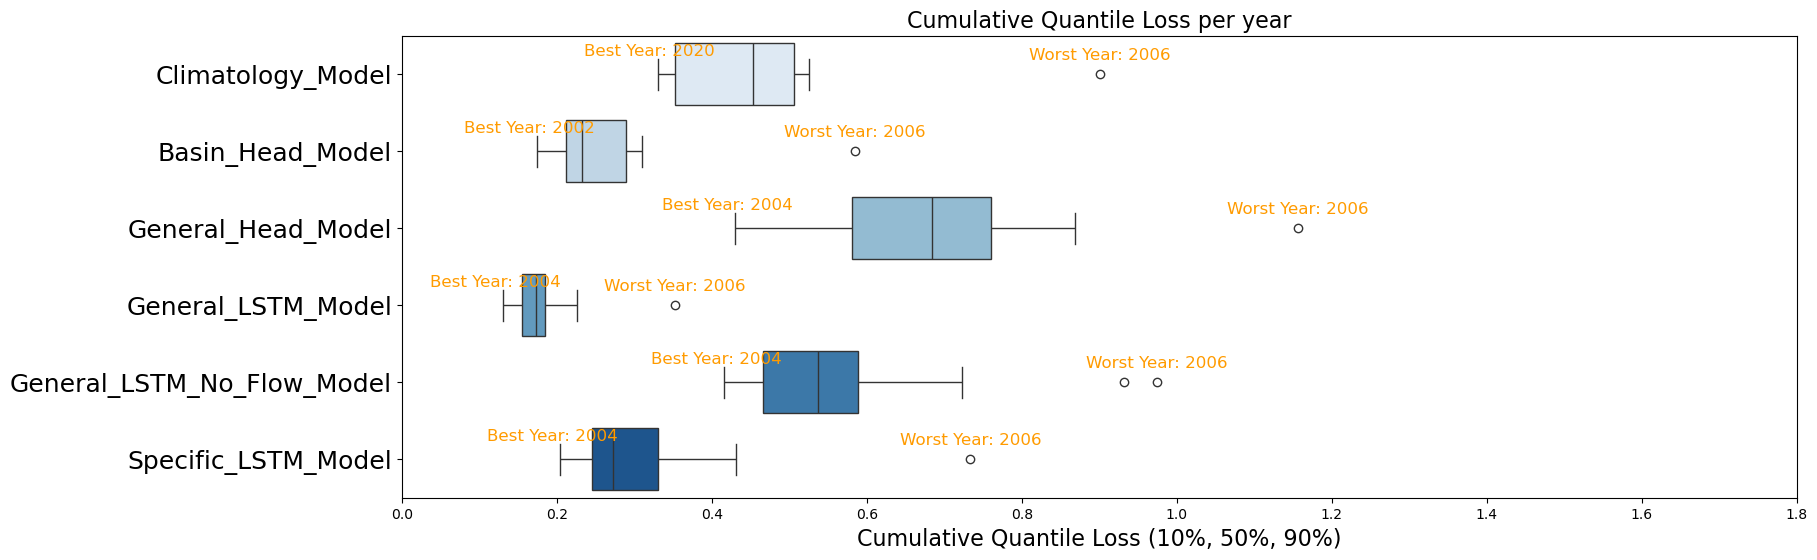

In [38]:
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import seaborn as sns

sns.color_palette('colorblind')
df = years_df #.drop(columns= 'Climatology_Model')
plt.figure(figsize=(18, 6))
sns.boxplot(data=df, orient = 'h', palette='Blues')


# Find the index of the best and worst points
best_indices = df.idxmin()
worst_indices = df.idxmax()

# Add text annotations to the plot for each column
for col in df.columns:
    best_index = best_indices[col]
    worst_index = worst_indices[col]
    
    best_point = df.loc[best_index, col]
    worst_point = df.loc[worst_index, col]
    
    plt.text(best_point - 0.01 , df.columns.get_loc(col) - 0.4, f'Best Year: {best_index}', ha='center', va='top', color='#ff9b00', fontsize=12)
    plt.text(worst_point , df.columns.get_loc(col) - 0.15, f'Worst Year: {worst_index}', ha='center', va='bottom', color='#ff9b00', fontsize=12)

plt.xlim([0,1.8])

plt.xlabel('Cumulative Quantile Loss (10%, 50%, 90%)', fontsize=16)
plt.yticks(fontsize=18)
plt.title('Cumulative Quantile Loss per year', fontsize=16)
plt.show()

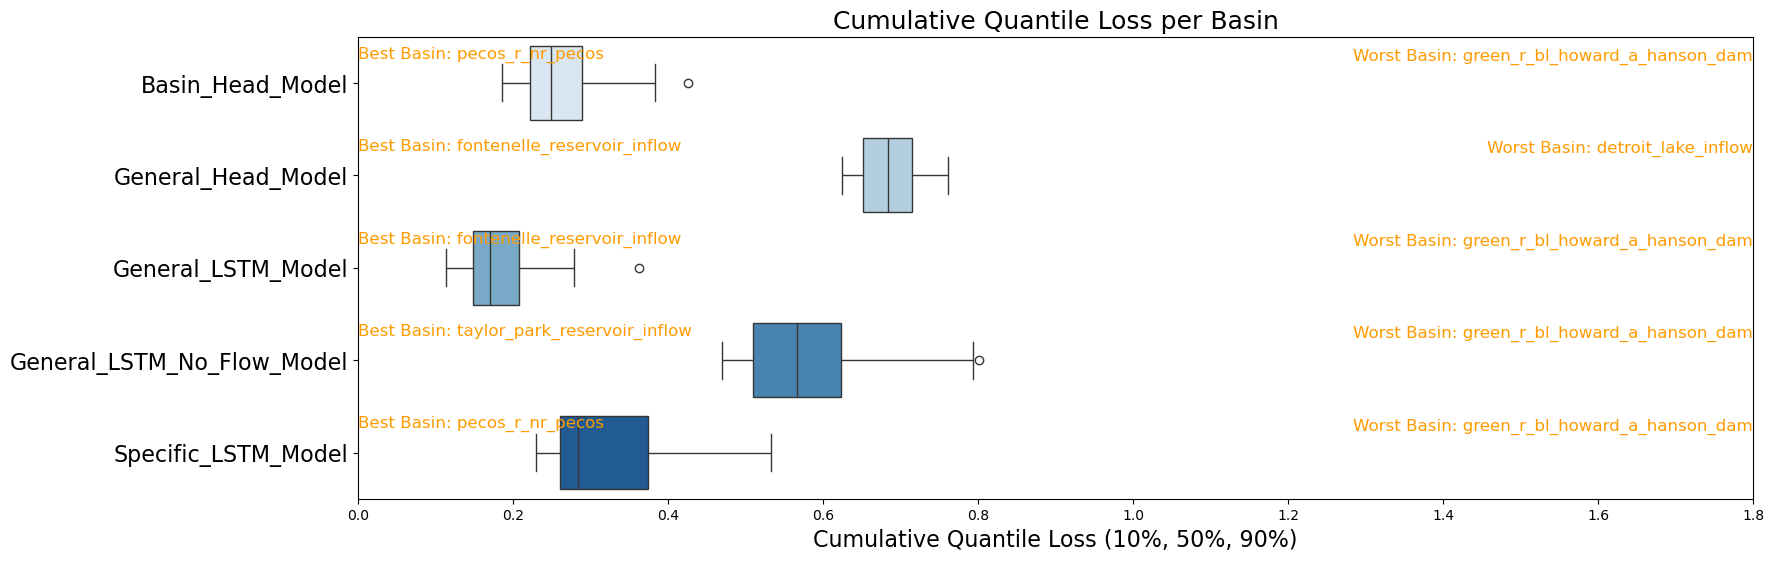

In [39]:
import seaborn as sns
df = basins_df.drop(columns= 'Climatology_Model')
plt.figure(figsize=(18, 6))
sns.boxplot(data=df, orient = 'h', palette='Blues')


# Find the index of the best and worst points
best_indices = df.idxmin()
worst_indices = df.idxmax()

# Add text annotations to the plot for each column
for col in df.columns:
    best_index = best_indices[col]
    worst_index = worst_indices[col]
    
    best_point = df.loc[best_index, col]
    worst_point = df.loc[worst_index, col]
    
    plt.text(0 , df.columns.get_loc(col) - 0.4, f'Best Basin: {best_index}', ha='left', va='top', color='#ff9b00', fontsize=12)
    plt.text(1.8, df.columns.get_loc(col) - 0.2, f'Worst Basin: {worst_index}', ha='right', va='bottom', color='#ff9b00', fontsize=12)


plt.xlim([0,1.8])
plt.xlabel('Cumulative Quantile Loss (10%, 50%, 90%)')

plt.xlabel('Cumulative Quantile Loss (10%, 50%, 90%)', fontsize=16)
plt.yticks(fontsize=16)

plt.title('Cumulative Quantile Loss per Basin', fontsize=18)
plt.show()

In [ ]:
basins_df[basins_df.index == 'libby_reservoir_inflow' ]

In [ ]:
years = np.arange(2000,2024,2)

for year in years :
    start_season_date = f'{year}-01-01' 
    end_season_date = f'{year}-06-26'
    basin = 'owyhee_r_bl_owyhee_dam'

            
    General_LSTM_Model = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{year}/General_LSTM_Model/General_LSTM.pth')
    Hydra_General_Head = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{year}/General_Head_Model/Hydra_Head_LSTM.pth')
    Hydra_Body = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{year}/General_Head_Model/Hydra_Body_LSTM.pth')
    Specific_Heads = {}
    Specific_Models = {}
    Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{year}/Basin_Head_Model/{basin}.path')
    Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{year}/Specific_LSTM_Model/{basin}_specific.pth') 
            

    Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False)
    _, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = False)
    _, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = True)
    
    Days = len(Basin_Head_Guesses)
    Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
    General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
    Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)

    General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
    Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)/7

    plot_predictions(General_Head_Guesses, Specific_LSTM_Guesses, General_LSTM_Guesses, Truth, f'{basin}', year, start_season_date, end_season_date)


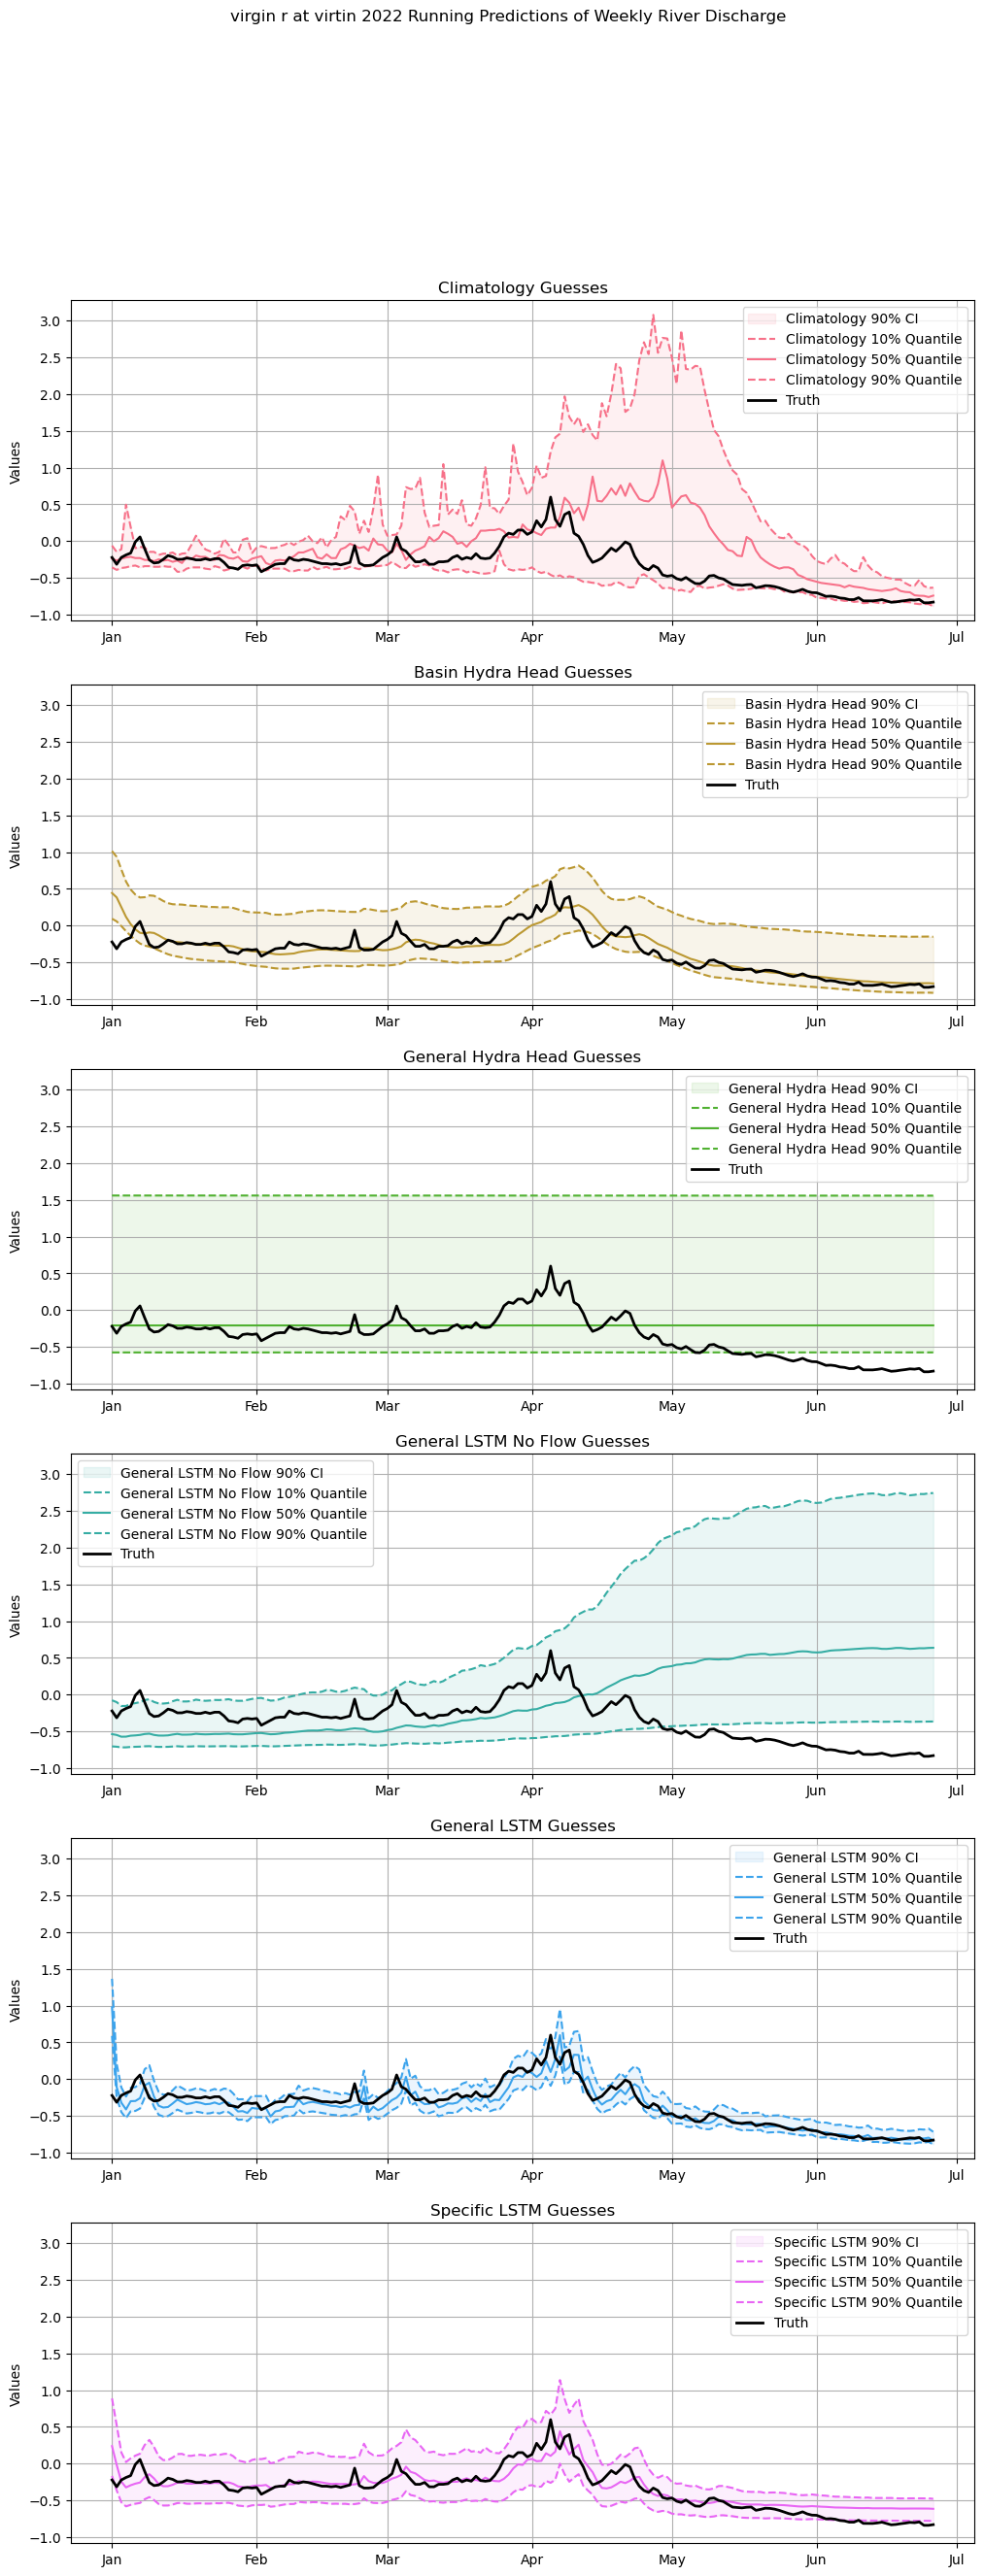

In [41]:
test_year = 2022

years_to_include = [year for year in years if year != test_year]
climatological_flows = calculate_climatological_flows(years_to_include, daily_flow)


basin = 'virgin_r_at_virtin'
daily_flow['virgin_r_at_virtin']

start_season_date = f'{test_year}-01-01' 
end_season_date = f'{test_year}-06-26'


        
General_LSTM_Model = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_LSTM_Model/General_LSTM.pth')
General_LSTM_No_Flow_Model = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_LSTM_No_Flow_Model/General_LSTM.pth')

Hydra_General_Head = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_Head_Model/Hydra_Head_LSTM.pth')
Hydra_Body = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/General_Head_Model/Hydra_Body_LSTM.pth')
Specific_Heads = {}
Specific_Models = {}
Specific_Heads[f'{basin}'] = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/Basin_Head_Model/{basin}.path')
Specific_Models[f'{basin}'] = torch.load(f'/data/Hydra_Work/1_Day_No_Forecast_Validation_Models/{test_year}/Specific_LSTM_Model/{basin}_specific.pth') 
        

Climatology_Guesses, Basin_Head_Guesses, General_Head_Guesses,  Truth = test_weekly_performance_hydra(basin, Hydra_Body, Hydra_General_Head, Specific_Heads, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False)
Climatology_Guesses, General_LSTM_Guesses,  _ = test_weekly_performance(basin, General_LSTM_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = False)
_, Specific_LSTM_Guesses, _ = test_weekly_performance(basin, Specific_Models, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = True)
_, General_LSTM_No_Flow_Guesses,  _ = test_weekly_performance(basin, General_LSTM_No_Flow_Model, era5, seasonal_forecasts, daily_flow, climatological_flows, climate_indices, static_variables, device, end_season_date, start_season_date,  furthest_distance = 120,  group_lengths = [1], feed_forcing = False, specialised = False, Flow = False)


Days = len(Basin_Head_Guesses)
Basin_Head_Guesses = np.array(Basin_Head_Guesses).reshape(Days , 3)
General_Head_Guesses = np.array(General_Head_Guesses).reshape(Days , 3)
Climatology_Guesses = np.array(Climatology_Guesses).reshape(Days , 3)
General_LSTM_No_Flow_Guesses = np.array(General_LSTM_No_Flow_Guesses).reshape(Days , 3)

General_LSTM_Guesses = np.array(General_LSTM_Guesses).reshape(Days , 3)
Specific_LSTM_Guesses = np.array(Specific_LSTM_Guesses).reshape(Days , 3)

guesses_list = [
    Climatology_Guesses,
    Basin_Head_Guesses,
    General_Head_Guesses,
    General_LSTM_No_Flow_Guesses,
    General_LSTM_Guesses,
    Specific_LSTM_Guesses
]

names_list = [
    'Climatology',
    'Basin Hydra Head',
    'General Hydra Head',
    'General LSTM No Flow',
    'General LSTM',
    'Specific LSTM'
]

all_plot_predictions(guesses_list, names_list, Truth, f'{basin}', test_year, start_season_date, end_season_date)


In [86]:
quantile_loss(General_LSTM_Guesses, np.array(Truth), np.array([0.1,0.5,0.9]))
quantile_loss(General_Head_Guesses, np.array(Truth), np.array([0.1,0.5,0.9]))


[0.10181492 0.15919273 0.11985008]
[0.06162159 0.12140085 0.19021195]


0.3732343828798308

In [12]:
from datetime import datetime, timedelta
import matplotlib.dates as mdates

def plot_predictions(Basin_Head_Guesses, Specific_LSTM_Guesses, General_LSTM_Guesses, Truth, basin, year, start_date, end_date):
    fig, axs = plt.subplots(3, 1, figsize=(12, 16), sharex= False)

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Calculate the number of days and generate date range
    days = (end_date - start_date).days
    dates = [start_date + timedelta(days=i) for i in range(days)]

    # Plot Basin Head Guesses
    axs[0].fill_between(range(len(Basin_Head_Guesses)), Basin_Head_Guesses[:, 0], Basin_Head_Guesses[:, 2], color='blue', alpha=0.1) # , label='General Hydra Head 90% CI'
    axs[0].plot(Basin_Head_Guesses[:, 0], color='blue', linestyle='--', label='General Hydra Head 10% Quantile')
    axs[0].plot(Basin_Head_Guesses[:, 1], color='blue', linestyle='-', label='General Hydra Head 50% Quantile')
    axs[0].plot(Basin_Head_Guesses[:, 2], color='blue', linestyle='--', label='General Hydra Head 90% Quantile')
    axs[0].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
    axs[0].set_ylabel('Values')
    axs[0].set_title('General Head Guesses')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Specific Model Guesses
    axs[1].fill_between(range(len(Specific_LSTM_Guesses)), Specific_LSTM_Guesses[:, 0], Specific_LSTM_Guesses[:, 2], color='purple', alpha=0.1)
    axs[1].plot(Specific_LSTM_Guesses[:, 0], color='purple', linestyle='--', label='Specific LSTM 10% Quantile')
    axs[1].plot(Specific_LSTM_Guesses[:, 1], color='purple', linestyle='-', label='Specific LSTM 50% Quantile')
    axs[1].plot(Specific_LSTM_Guesses[:, 2], color='purple', linestyle='--', label='Specific LSTM 90% Quantile')
    axs[1].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
    axs[1].set_ylabel('Values')
    axs[1].set_title('Specific LSTM Guesses')
    axs[1].legend()
    axs[1].grid(True)

    # Plot General LSTM Guesses
    axs[2].fill_between(range(len(General_LSTM_Guesses)), General_LSTM_Guesses[:, 0], General_LSTM_Guesses[:, 2], color='green', alpha=0.1)
    axs[2].plot(General_LSTM_Guesses[:, 0], color='green', linestyle='--', label='General LSTM 10% Quantile')
    axs[2].plot(General_LSTM_Guesses[:, 1], color='green', linestyle='-', label='General LSTM 50% Quantile')
    axs[2].plot(General_LSTM_Guesses[:, 2], color='green', linestyle='--', label='General LSTM 90% Quantile')
    axs[2].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
    axs[2].set_ylabel('Values')
    axs[2].set_title('General LSTM Guesses')
    axs[2].set_xlabel('Index')
    axs[2].legend()
    axs[2].grid(True)

    # Set the same y-limits for all subplots
    y_limits = [
        axs[0].get_ylim(),
        axs[1].get_ylim(),
        axs[2].get_ylim(),
    ]

    common_y_limits = (min([lim[0] for lim in y_limits]), max([lim[1] for lim in y_limits]))

    for ax in axs:
        ax.set_ylim(common_y_limits)
        # Format the x-axis to show months
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


    formatted_basin = basin.replace('_', ' ')
    # Customize the plot
    plt.suptitle(f'{formatted_basin} {year} Running Predictions of Weekly River Discharge ')


    # Show the plot
    plt.show()

# Example usage (assuming you have the data arrays):


In [ ]:
# Plot the data
plt.figure(figsize=(12, 8))

# Plot Basin Head Guesses
plt.plot(Basin_Head_Guesses[:, 0], color='blue', linestyle='--', label='Basin Head Guess 1')
plt.plot(Basin_Head_Guesses[:, 1], color='blue', linestyle='-', label='Basin Head Guess 2')
plt.plot(Basin_Head_Guesses[:, 2], color='blue', linestyle='--', label='Basin Head Guess 3')

# # Plot General Head Guesses
plt.plot(General_Head_Guesses[:, 0], color='orange', linestyle='--', label='General Head Guess 1')
plt.plot(General_Head_Guesses[:, 1], color='orange', linestyle='-', label='General Head Guess 2')
plt.plot(General_Head_Guesses[:, 2], color='orange', linestyle='--', label='General Head Guess 3')

# # Plot General Guesses
# plt.plot(General_LSTM_Guesses[:, 0], color='cyan', linestyle='--', label='General LSTM Guess 1')
# plt.plot(General_LSTM_Guesses[:, 1], color='cyan', linestyle='-', label='General LSTM Guess 2')
# plt.plot(General_LSTM_Guesses[:, 2], color='cyan', linestyle='--', label='General LSTM Guess 3')

# Plot Specific Model Guesses
# plt.plot(Specific_LSTM_Guesses[:, 0]/7, color='purple', linestyle='--', label='Specific LSTM Guess 1')
# plt.plot(Specific_LSTM_Guesses[:, 1]/7, color='purple', linestyle='-', label='Specific LSTM Guess 2')
# plt.plot(Specific_LSTM_Guesses[:, 2]/7, color='purple', linestyle='--', label='Specific LSTM Guess 3')


#Plot Climatology Guesses
# plt.plot(Climatology_Guesses[:, 0], color='grey', linestyle='--', label='Climatology Guess 1')
# plt.plot(Climatology_Guesses[:, 1], color='grey', linestyle='-', label='Climatology Guess 2')
# plt.plot(Climatology_Guesses[:, 2], color='grey', linestyle='--', label='Climatology Guess 3')


# Plot Truth
plt.plot(np.array(Truth), color='black', linestyle='-', linewidth=2, label='Truth')

    # Customize the plot
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Running Weekly Predictions of River Dishcarge for Various Models')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [40]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def all_plot_predictions(guesses_list, names_list, Truth, basin, year, start_date, end_date):
    num_models = len(guesses_list)
    fig, axs = plt.subplots(num_models, 1, figsize=(12, 5 * num_models), sharex=False)

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Calculate the number of days and generate date range
    days = (end_date - start_date).days
    dates = [start_date + timedelta(days=i) for i in range(days)]

    colors = sns.color_palette("husl", num_models)

    for i in range(num_models):
        guesses = guesses_list[i]
        name = names_list[i]
        color = colors[i]
        
        axs[i].fill_between(range(len(guesses)), guesses[:, 0], guesses[:, 2], color=color, alpha=0.1, label=f'{name} 90% CI')
        axs[i].plot(guesses[:, 0], color=color, linestyle='--', label=f'{name} 10% Quantile')
        axs[i].plot(guesses[:, 1], color=color, linestyle='-', label=f'{name} 50% Quantile')
        axs[i].plot(guesses[:, 2], color=color, linestyle='--', label=f'{name} 90% Quantile')
        axs[i].plot(Truth, color='black', linestyle='-', linewidth=2, label='Truth')
        axs[i].set_ylabel('Values')
        axs[i].set_title(f'{name} Guesses')
        axs[i].legend()
        axs[i].grid(True)

    # Set the same y-limits for all subplots
    y_limits = [ax.get_ylim() for ax in axs]
    common_y_limits = (min(lim[0] for lim in y_limits), max(lim[1] for lim in y_limits))

    for ax in axs:
        ax.set_ylim(common_y_limits)
        # Format the x-axis to show months
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    formatted_basin = basin.replace('_', ' ')
    # Customize the plot
    plt.suptitle(f'{formatted_basin} {year} Running Predictions of Weekly River Discharge')

    # Show the plot
    plt.show()